In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import seaborn as sns
from scipy.stats import entropy, zscore,  pearsonr,spearmanr, linregress
import scipy.spatial.distance as scist
import csv
import konlpy
nlp_tagger = konlpy.tag.Okt()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pandas as pd

subjects =  ['sub-EZ9NM','sub-TV7EF','sub-WLC4O','sub-3L109','sub-3UYSS','sub-JVPPA','sub-EDOP8',
             'sub-TIJD1','sub-AYDLR','sub-98UT7','sub-4G9A5','sub-YJBI8','sub-FG8PD','sub-BBN4K',
             'sub-F61IR','sub-M1ZRL','sub-NZJZN','sub-XZ9SS','sub-L05R3','sub-ZOVPY','sub-6PEOF',
             'sub-G6RPG','sub-TPNCU','sub-9ADGJ','sub-27IXQ','sub-NDX5S','sub-OE7EZ','sub-28E84',
             'sub-ENN9N','sub-28OBV','sub-8WJAP','sub-SPHBN','sub-WP8SX','sub-BG4CW','sub-AVQEZ',
             'sub-YLWD1','sub-0A4MV','sub-8PIML','sub-4T7NM','sub-X5RE0','sub-RUQON','sub-JVT46',
             'sub-RTFX9','sub-OWWAF','sub-IC2KG','sub-S3I4J','sub-XFQA1','sub-UKF5L','sub-Z0MJJ',
             'sub-9HMVR','sub-DBQ8H','sub-NAD3W','sub-KH33B','sub-JASQ6','sub-T6FHZ','sub-PQ8JD',
             'sub-NOVID','sub-XAKBX','sub-JVSIQ','sub-D1FKN','sub-R3JA3','sub-GPMCX','sub-H8QL5',
             'sub-6HW3V','sub-WF939']

event_segmentation = pd.read_csv('../utils/movie_event_segmentation.csv')

n_events = len(event_segmentation)
event_times = []
for event in range(n_events):
    event_times.append(np.arange(event_segmentation['on time'][event], event_segmentation['off time'][event], 2))

event_dict = {}
for event in range(n_events):
    for time in event_times[event]:
        event_dict[time] = event

event_words = {}
for event in range(n_events):
    event_words[event] = []

for event in range(n_events):
    try:
        for word in event_segmentation['dictionary'][event].split():
            event_words[event].append(word)
    except:
        pass

movie_user_dictionary = pd.read_csv('../utils/movie_user_dictionary.csv')
user_dictionary = {}
before_words = []
for i in range(len(movie_user_dictionary)):
    before_word = movie_user_dictionary['before'][i]
    after_word = movie_user_dictionary['after'][i]
    user_dictionary[before_word] = after_word
    before_words.append(before_word)


In [2]:
movie_annotation = '../utils/movie_korean_annotation.csv'
passed_pos = ['Noun', 'Verb']
num_cols=4

window_size_ref = 0
num_topic = 80
window_size_recall = 0
threshold = 0.3
num_iterations = 50

ref_words = []
with open(movie_annotation, 'r', encoding="utf-8") as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        data = []
        current_event = event_dict[int(row[0])]
        for col in range(num_cols):
            for word, pos in nlp_tagger.pos(row[2+col], stem=True):
                if pos in passed_pos:
                    data.append(word)
        ref_words.append(' '.join([word for word in data] + event_words[current_event]))


ref_words_ngram = []
for i in range(len(ref_words)):
    if i < window_size_ref:
        ref_words_ngram.append(' '.join(ref_words[0:i + window_size_ref+1]))
    else:
        ref_words_ngram.append(' '.join(ref_words[i-window_size_ref:i + window_size_ref+1]))
mrbean_ref = np.array(ref_words_ngram)

amount_recalls = np.zeros((len(subjects), 300))
for f, fname in enumerate(subjects):
    print(fname)
    np.random.seed(0) #for reproducibility
    recall_acc_matrix = []
    for seed in range(num_iterations):
        countvector_model = CountVectorizer().fit(mrbean_ref)
        lda_model = LatentDirichletAllocation(n_components=num_topic,
                                              learning_method='batch')
        lda_model.fit(countvector_model.transform(mrbean_ref))

        ref_model = lda_model.transform(countvector_model.transform(mrbean_ref))
        ref_pd = np.nansum((1 - scist.cdist(ref_model, ref_model, 'cosine')), axis=1)


        mrbean_fname = '/DATA/FilmMemory_preprocess/recall_data/'+fname+'_recall.txt'
        recall_words = []
        recall_sents = []
        with open(mrbean_fname, 'r', encoding='utf-8') as file:
            for line in file.readlines():
                bow = []
                for word, pos in nlp_tagger.pos(line, stem=True):
                    if pos in passed_pos:
                        if word in before_words:
                            bow.append(user_dictionary[word])
                            recall_words.append(user_dictionary[word])
                        else:
                            bow.append(word)
                            recall_words.append(word)
                recall_sents.append(' '.join([word for word in bow]))

        mrbean_recall = []
        for i in range(len(recall_sents)):
            if i < window_size_recall:
                mrbean_recall.append(' '.join(recall_sents[0:i + window_size_recall+1]))
            else:
                mrbean_recall.append(' '.join(recall_sents[i-window_size_recall:i + window_size_recall+1]))

        recall_model = lda_model.transform(countvector_model.transform(mrbean_recall))

        recall_acc = (1 - scist.cdist(ref_model, recall_model, 'cosine'))
        recall_acc_matrix.append(recall_acc)
    amount_recalls[f,:] = np.mean(recall_acc_matrix, axis=0).mean(axis=1)

np.save('Figure4_amount_recalls.npy', amount_recalls)

sub-001


FileNotFoundError: [Errno 2] No such file or directory: '/DATA/FilmMemory_preprocess/recall_data/sub-001_recall.txt'

Ttest_indResult(statistic=-2.236994725359332, pvalue=0.042072321368850335)


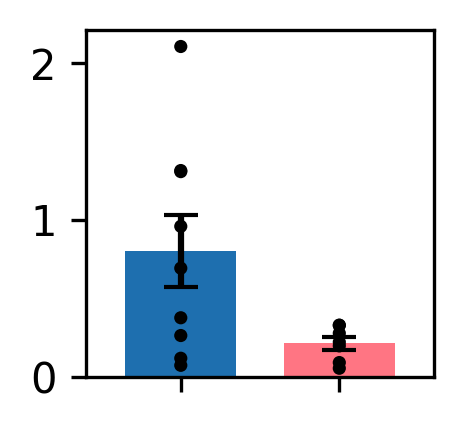

In [45]:
from scipy.stats import sem
immediate_color = '#ff7583'
immediate_control_color = '#ba535e'
delayed_color = '#1E6FAF' #'#004e8c'
delayed_control_color = '#3e627e'

immediate_stitch = [35, 52, 88, 155, 190, 242, 260]
delayed_stitch = [17, 71, 105, 122, 138, 173, 208, 225, 280]
amount_recalls = np.load('data/amount_recalls.npy')
plt.style.use('default')
average_recall = np.mean(zscore(amount_recalls, axis=1), axis=0)
immediate_std = []
delayed_std = []
length = 5
for i in immediate_stitch:
    immediate_std.append(np.abs(np.mean(average_recall[i:i+length])-np.mean(average_recall[i-length:i])))
for i in delayed_stitch:
    delayed_std.append(np.abs(np.mean(average_recall[i:i+length])-np.mean(average_recall[i-length:i])))

plt.figure(figsize=(1.5,1.5), dpi=300)
plt.bar([1,0], [np.mean(immediate_std), np.mean(delayed_std)],
        color=[immediate_color, delayed_color], width=0.7,
        yerr=[sem(immediate_std),
              sem(delayed_std)],
        capsize=4)
plt.scatter((1)*np.ones(len(immediate_std)), immediate_std, zorder=100, s=10, facecolors='k', alpha=1.0, edgecolors='none')
plt.scatter((0)*np.ones(len(delayed_std)), delayed_std, zorder=100, s=10, facecolors='k', alpha=1.0, edgecolors='none')
from scipy.stats import ttest_ind
plt.xlim(-0.6, 1.6)
plt.xticks([0,1], ["", ""])
print(ttest_ind(immediate_std, delayed_std))